In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split


from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score

from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold

from tqdm.auto import tqdm

In [5]:
#!curl -O  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed

  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
  0     0    0     0    0     0      0      0 --:--:--  0:00:01 --:--:--     0
 10 80876   10  8268    0     0   4871      0  0:00:16  0:00:01  0:00:15  4927
100 80876  100 80876    0     0  39789      0  0:00:02  0:00:02 --:--:-- 40196


In [102]:
df = pd.read_csv('course_lead_scoring.csv')

In [104]:
df.head()

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NaN,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NaN,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1


In [106]:
categorical = ['lead_source','industry','employment_status','location']
numerical = ['number_of_courses_viewed', 'annual_income','interaction_count', 'lead_score']

In [108]:
df['lead_source'] = df.lead_source.fillna('NA')
df['industry'] = df.industry.fillna('NA')
df['employment_status'] = df['employment_status'].fillna('NA')
df['location'] = df['location'].fillna('NA')
df['annual_income'] = df.annual_income.fillna(0.0)

In [110]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [112]:
len(df), len(df_full_train), len(df_val), len(df_test)

(1462, 1169, 293, 293)

In [114]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [116]:
y_train = df_train.converted.values
y_val = df_val.converted.values
y_test = df_test.converted.values

In [118]:
del df_train['converted']
del df_val['converted']
del df_test['converted']

## Question 1: ROC AUC feature importance

In [121]:
for feature in numerical:
    print(f"{feature} : {roc_auc_score(y_train, df_train[feature])}")

number_of_courses_viewed : 0.7635680590007088
annual_income : 0.5519578313253012
interaction_count : 0.738270176293409
lead_score : 0.6144993577250176


## Question 2: Training the model

In [124]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [126]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]

In [128]:
fpr, tpr, thresholds = roc_curve(y_val, y_pred)

In [130]:
round(auc(fpr, tpr), 2)

0.82

In [132]:
round(roc_auc_score(y_val, y_pred), 2)

0.82

## Question 3: Precision and Recall

In [135]:
scores = []

for threshold in np.arange(0.0, 1.01, 0.01):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    scores.append((threshold, tp, fp, fn, tn, p, r))

C:\Users\Admin-IT\AppData\Local\Temp\ipykernel_19300\1136317028.py:16: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


In [137]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'p', 'r']
df_scores = pd.DataFrame(scores, columns=columns)

In [139]:
df_scores

,threshold,tp,fp,fn,tn,p,r
0,0.00,171,122,0,0,0.583618,1.000000
1,0.01,171,122,0,0,0.583618,1.000000
2,0.02,171,122,0,0,0.583618,1.000000
3,0.03,171,122,0,0,0.583618,1.000000
4,0.04,171,122,0,0,0.583618,1.000000
...,...,...,...,...,...,...,...
96,0.96,3,0,168,122,1.000000,0.017544
97,0.97,1,0,170,122,1.000000,0.005848
98,0.98,0,0,171,122,NaN,0.000000
99,0.99,0,0,171,122,NaN,0.000000


In [141]:
df_scores['diff'] = abs(df_scores['p'] - df_scores['r'])
closest = df_scores.loc[df_scores['diff'].idxmin()]

print(f"Precision and recall are closest at threshold = {closest['threshold']:.3f}")

Precision and recall are closest at threshold = 0.640


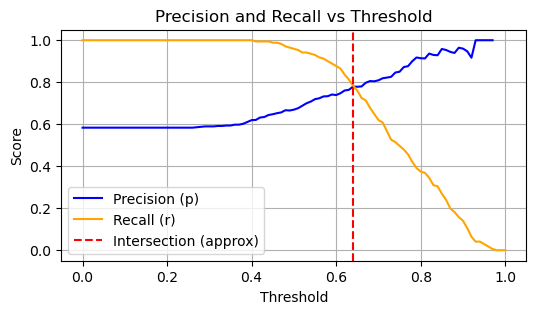

In [147]:
plt.figure(figsize=(6,3))
plt.plot(df_scores['threshold'], df_scores['p'], label='Precision (p)', color='blue')
plt.plot(df_scores['threshold'], df_scores['r'], label='Recall (r)', color='orange')

plt.axvline(x=closest['threshold'], color='red', linestyle='--', label='Intersection (approx)')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

In [149]:
print(np.abs(0.545-0.640))
print(np.abs(0.745-0.640))

0.09499999999999997
0.10499999999999998


## Question 4: F1 score

In [154]:
f1_scores = []

for threshold in np.arange(0.0, 1.01, 0.01):
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= threshold)
    predict_negative = (y_pred < threshold)
    
    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()
    
    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()

    p = tp / (tp + fp)
    r = tp / (tp + fn)
    
    f1 = 2 * ((p*r) / (p+r))
    
    f1_scores.append((threshold, tp, fp, fn, tn, p, r, f1))

C:\Users\Admin-IT\AppData\Local\Temp\ipykernel_19300\2963515970.py:16: RuntimeWarning: invalid value encountered in scalar divide
  p = tp / (tp + fp)


In [156]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'p', 'r', 'f1']
df_f1 = pd.DataFrame(f1_scores, columns=columns)

In [158]:
df_f1

,threshold,tp,fp,fn,tn,p,r,f1
0,0.00,171,122,0,0,0.583618,1.000000,0.737069
1,0.01,171,122,0,0,0.583618,1.000000,0.737069
2,0.02,171,122,0,0,0.583618,1.000000,0.737069
3,0.03,171,122,0,0,0.583618,1.000000,0.737069
4,0.04,171,122,0,0,0.583618,1.000000,0.737069
...,...,...,...,...,...,...,...,...
96,0.96,3,0,168,122,1.000000,0.017544,0.034483
97,0.97,1,0,170,122,1.000000,0.005848,0.011628
98,0.98,0,0,171,122,NaN,0.000000,NaN
99,0.99,0,0,171,122,NaN,0.000000,NaN


In [160]:
df_f1['f1'].max()

0.8124999999999999

In [162]:
df_f1['threshold'][df_f1['f1'].idxmax()]

0.5700000000000001

In [164]:
df_f1.iloc[57]

threshold      0.570000
tp           156.000000
fp            57.000000
fn            15.000000
tn            65.000000
p              0.732394
r              0.912281
f1             0.812500
Name: 57, dtype: float64

## Question 5: 5-Fold CV

In [169]:
!pip install tqdm

In [173]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

scores = []

for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values
    
    train_dicts = df_train[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(train_dicts)
    
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000) 
    model.fit(X_train, y_train)
    
    val_dicts = df_val[categorical + numerical].to_dict(orient='records')
    X_val = dv.transform(val_dicts)
    
    y_pred = model.predict_proba(X_val)[:, 1]

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.822 +- 0.036


## Question 6: Hyperparameter Tuning

In [178]:
for C in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.converted.values
        y_val = df_val.converted.values

        train_dicts = df_train[categorical + numerical].to_dict(orient='records')

        dv = DictVectorizer(sparse=False)
        X_train = dv.fit_transform(train_dicts)

        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000) 
        model.fit(X_train, y_train)

        val_dicts = df_val[categorical + numerical].to_dict(orient='records')
        X_val = dv.transform(val_dicts)

        y_pred = model.predict_proba(X_val)[:, 1]

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s --> %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

C=1e-06 --> 0.560 +- 0.024
C=0.001 --> 0.867 +- 0.029
C=1 --> 0.822 +- 0.036
